In [1]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, DDPMPipeline, UNet2DModel
from utils.helper import make_transform, show_images, train_model, sample_images

In [2]:
image_size = 32
batch_size = 64

lr = 4e-4
epochs=30
N_TIMESTEPS = 1000

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Repo card metadata block was not found. Setting CardData to empty.


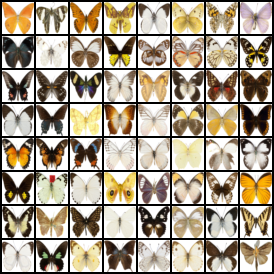

In [3]:
dataset.set_transform(make_transform(img_size=image_size))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
images = next(iter(train_loader))["images"].to(device)
show_images(images)

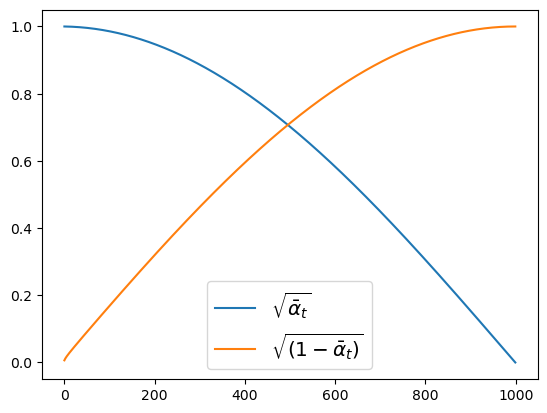

In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=N_TIMESTEPS, beta_schedule="squaredcos_cap_v2")
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

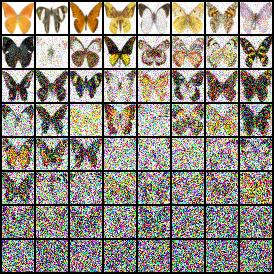

In [5]:
timesteps = torch.linspace(0, N_TIMESTEPS - 1, 64).long().to(device)
noise = torch.randn_like(images)
noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
show_images(noisy_images)

In [6]:
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2, # Amount of ResNet layers per UNet block
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

Epoch:5, loss: 0.1531830271705985
Epoch:10, loss: 0.1148648108355701
Epoch:15, loss: 0.1012043789960444
Epoch:20, loss: 0.08753428002819419
Epoch:25, loss: 0.08894877973943949
Epoch:30, loss: 0.07295935763977468


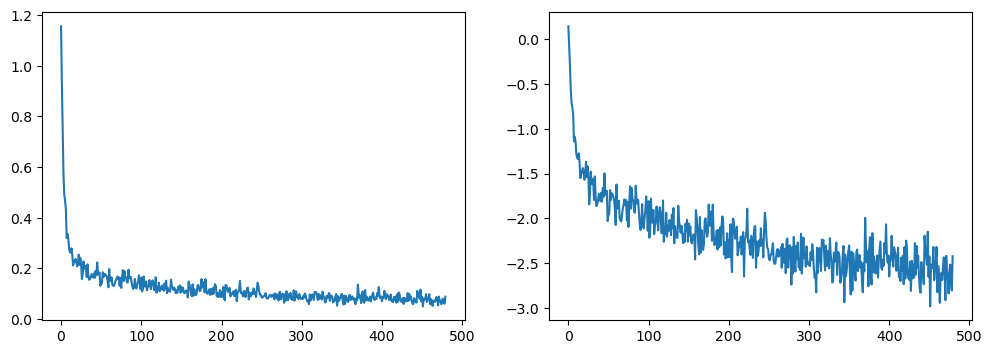

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train_model(model, noise_scheduler, train_loader, optimizer, epochs, device)

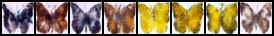

In [8]:
sample = sample_images(model, noise_scheduler, device)
show_images(sample)

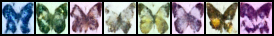

In [11]:
model_loaded = UNet2DModel.from_pretrained("pipeline/unet").to(device)
scheduler_loaded = DDPMScheduler.from_pretrained("pipeline/scheduler")
sample = sample_images(model_loaded, noise_scheduler=scheduler_loaded, device=device)
show_images(sample)